<a href="https://colab.research.google.com/github/Ronit-Desai/BCI-Neural-Network-Creation/blob/main/BCI_Neural_Network_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial will go through the steps of creating and training a neural network on EEG data. Installation instructions are provided if you would like to follow along locally, but all steps are shown with their respective outputs in this collab document. 


---



# (Step 1) Set Up the Environment


Before we begin, please ensure that you have a local Python version of at least `Python 3.5` or greater. If you do not have a compatible Python version yet, please see the [Python Beginners Guide](https://wiki.python.org/moin/BeginnersGuide/Download) for installation instructions

The prerequisite packages to this tutorial are:


*   [**MNE**](https://mne.tools/stable/install/mne_python.html#installing-mne-python-and-its-dependencies): EEG Data Package
*   [**NumPy**](https://www.scipy.org/install.html): Scientific Computing (SciPy Download Page)
*   [**SciPy**](https://www.scipy.org/install.html): Scientific Computing
*   [**MatPlotLib**](https://matplotlib.org/users/installing.html): Plotting Library
*   [**Scikit-Learn**](https://scikit-learn.org/stable/install.html): Machine Learning Library
*   [**PyTorch**](https://pytorch.org/get-started/locally/): Machine Learning Library

Below is a pip script that installs these libraries on Google Collab. If any do not work, please see their respective installation pages.

In [ ]:
# Run these from the console if following along locally
!pip install mne
!pip install sklearn
!pip install matplotlib
!pip install torch 
!pip install torchvision
!pip install tensorboardX

For the purposes of this tutorial, we will be turning off warnings.

In [ ]:
# You'll want to comment this out if you plan on modifying this code, to get valuable feedback
import warnings
warnings.filterwarnings('ignore')

Import all of our required modules. This includes various submodules that we'll need including the RobustScaler object from scikit.

In [ ]:
from collections import OrderedDict
from pylab import rcParams
import torch
import torch.nn as nn
import torchvision.transforms
import matplotlib.pyplot as plt
import numpy as np
import mne
from sklearn.preprocessing import RobustScaler

# (Step 2) Initialize Parameters

Set the randomizer seed for *some* consistency



In [ ]:
torch.manual_seed(100)

Initialize our project with a few constant parameters.


*   **eeg_sample_count**:  Number of samples we're training our network with
*   **learning_rate**:     How fast the network tends to change its weights
*   **eeg_sample_length**: Number of datapoints per sample
*   **number_of_classes**: Number of output classes (1 output variable with 1.0 = 100%, 0.0 = 0% certainty that this sample has a p300)
*   **hidden1**: Number of neurons in the first hidden layer
*   **hidden2**: Number of neurons in the second hidden layer
*   **hidden3**: Number of neurons in the third hidden layer
*   **output**: Number of neurons in the output layer





In [ ]:
# Initialize parameters
eeg_sample_count = 240 # How many samples are we training
learning_rate = 1e-3 # How hard the network will correct its mistakes while learning
eeg_sample_length = 226 # Number of eeg data points per sample
number_of_classes = 1 # We want to answer the "is this a P300?" question
hidden1 = 500 # Number of neurons in our first hidden layer
hidden2 = 1000 # Number of neurons in our second hidden layer
hidden3 = 100 # Number of neurons in our third hidden layer
output = 10 # Number of neurons in our output layer

# (Step 3) Create Sample Data

Before we jump into creating a network and training it with the MNE dataset, it is good practice to first test that the network is working correctly with simple, easily classifiable data. The code in this block creates a sample dataset with the same dimensions as the actual data set.

In [ ]:
## Create sample data using the parameters
sample_positives = [None, None] # Element [0] is the sample, Element [1] is the class
sample_positives[0] = torch.rand(int(eeg_sample_count / 2), eeg_sample_length) * 0.50 + 0.25
sample_positives[1] = torch.ones([int(eeg_sample_count / 2), 1], dtype=torch.float32)

sample_negatives = [None, None] # Element [0] is the sample, Element [1] is the class
sample_negatives_low = torch.rand(int(eeg_sample_count / 4), eeg_sample_length) * 0.25
sample_negatives_high = torch.rand(int(eeg_sample_count / 4), eeg_sample_length) * 0.25 + 0.75
sample_negatives[0] = torch.cat([sample_negatives_low, sample_negatives_high], dim = 0)
sample_negatives[1] = torch.zeros([int(eeg_sample_count / 2), 1], dtype=torch.float32)

samples = [None, None] # Combine the two
samples[0] = torch.cat([sample_positives[0], sample_negatives[0]], dim = 0)
samples[1] = torch.cat([sample_positives[1], sample_negatives[1]], dim = 0)

## Create test data that isn't trained on
test_positives = torch.rand(10, eeg_sample_length) * 0.50 + 0.25 # Test 10 good samples
test_negatives_low = torch.rand(5, eeg_sample_length) * 0.25 # Test 5 bad low samples
test_negatives_high = torch.rand(5, eeg_sample_length) * 0.25 + 0.75 # Test 5 bad high samples
test_negatives = torch.cat([test_negatives_low, test_negatives_high], dim = 0)

print("We have created a sample dataset with " + str(samples[0].shape[0]) + " samples")
print("Half of those are positive samples with a score of 100%")
print("Half of those are negative samples with a score of 0%")
print("We have also created two sets of 10 test samples to check the validity of the network")

We have created a sample dataset with 240 samples
Half of those are positive samples with a score of 100%
Half of those are negative samples with a score of 0%
We have also created two sets of 10 test samples to check the validity of the network


# (Step 4) Understand the Sample Data

Below is a graph displaying a representation of this dataset.
The average of the "good" class 1 samples is represented by the green line. You can see that it is characterized for having values around 0.5 and a larger amplitude than the "bad" class. 
Two averages of the "bad" class 0 samples are at the top and bottom edges represented by the red lines. We created two "bad" classes, both of them with a smaller amplitude than the "good" classes and centered either around 0.25 or 0.75. 
An example for each of these classes is plotted in light gray.

We will now design our network around this sample data. If the network classifies this data correctly, it will be more likely to classify the actual, and more complicated, dataset correctly.



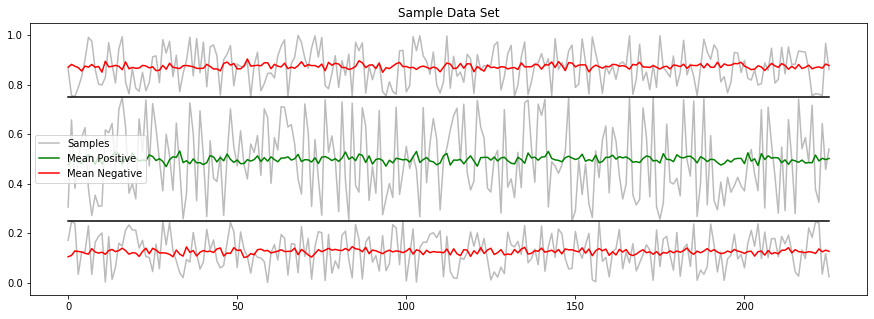

In [ ]:
rcParams['figure.figsize'] = 15, 5

plt.title("Sample Data Set")
plt.plot(list(range(0, eeg_sample_length)), sample_positives[0][0], color = "#bbbbbb", label = "Samples")
plt.plot(list(range(0, eeg_sample_length)), sample_positives[0].mean(dim = 0), color = "g", label = "Mean Positive")
plt.plot(list(range(0, eeg_sample_length)), sample_negatives_high[0], color = "#bbbbbb")
plt.plot(list(range(0, eeg_sample_length)), sample_negatives_high.mean(dim = 0), color = "r", label = "Mean Negative")
plt.plot(list(range(0, eeg_sample_length)), sample_negatives_low[0], color = "#bbbbbb")
plt.plot(list(range(0, eeg_sample_length)), sample_negatives_low.mean(dim = 0), color = "r")
plt.plot(list(range(0, eeg_sample_length)), [0.75] * eeg_sample_length, color = "k")
plt.plot(list(range(0, eeg_sample_length)), [0.25] * eeg_sample_length, color = "k")
plt.legend()
plt.show()

# (Step 5) Creating the Neural Network

This neural network has several distinct components that can be customized. Below, we define the network graph as sets of linear nodes and activation nodes. The defined graph roughly coresponds to this image: <Image>

Our input data will be traveling along this graph, accumulating biases, scaled by weights, and being transformed by activation functions, until it passes through the final output node. It is then passed through a `sigmoid` function which scales the final value into a number between 0 and 1. 

This final number is the p300 predictor.

In [ ]:
## Define the network
tutorial_model = nn.Sequential()

# Input Layer (Size 226 -> 500)
tutorial_model.add_module('Input Linear', nn.Linear(eeg_sample_length, hidden1))
tutorial_model.add_module('Input Activation', nn.CELU()) 

# Hidden Layer (Size 500 -> 1000)
tutorial_model.add_module('Hidden Linear', nn.Linear(hidden1, hidden2))
tutorial_model.add_module('Hidden Activation', nn.ReLU())

# Hidden Layer (Size 1000 -> 100)
tutorial_model.add_module('Hidden Linear2', nn.Linear(hidden2, hidden3))
tutorial_model.add_module('Hidden Activation2', nn.ReLU())

# Hidden Layer (Size 100 -> 10)
tutorial_model.add_module('Hidden Linear3', nn.Linear(hidden3, 10))
tutorial_model.add_module('Hidden Activation3', nn.ReLU())

# Output Layer (Size 10 -> 1)
tutorial_model.add_module('Output Linear', nn.Linear(10, number_of_classes))
tutorial_model.add_module('Output Activation', nn.Sigmoid())

Next, we need training and loss functions. Loss functions are vital in giving us feedback on how well the network is training. A zero or near-zero loss means that the network is accurately predicting the set of training data. We can use this number to determine when the network is "done" training.

In the code below, we define a common loss function available in PyTorch to use and a simple training procedure that updates the network's weights and calculates the loss for every iteration.

In [ ]:
# Define a loss function
loss_function = torch.nn.MSELoss()

# Define a training procedure
def train_network(train_data, actual_class, iterations):

  # Keep track of loss at every training iteration
  loss_data = []

  # Begin training for a certain amount of iterations
  for i in range(iterations):

    # Begin with a classification
    classification = tutorial_model(train_data)

    # Find out how wrong the network was
    loss = loss_function(classification, actual_class)
    loss_data.append(loss.item())

    # Zero out the optimizer gradients every iteration
    optimizer.zero_grad()

    # Teach the network how to do better next time
    loss.backward()
    optimizer.step()
  
  # Plot a nice loss graph at the end of training
  rcParams['figure.figsize'] = 10, 5
  plt.title("Loss vs Iterations")
  plt.plot(list(range(0, len(loss_data))), loss_data)
  plt.show()

# Save the network's default state so we can retrain from the default weights
torch.save(tutorial_model, "/home/tutorial_model_default_state")

# (Step 6) Verify the Network Works

Now we're ready to train the network on our sample data! We need to define an optimizer that determines how the network is trained, but that is a simple one line of code using PyTorch. The learning rate variable we provide will determine how fast the network will try to learn. This variable is determined mostly by trial and error.

As defined in our training function, a graph will be displayed showing our loss vs iteration. If the loss tends towards 0.00, we're likely on the right track.

Below is the loss graph for our training session


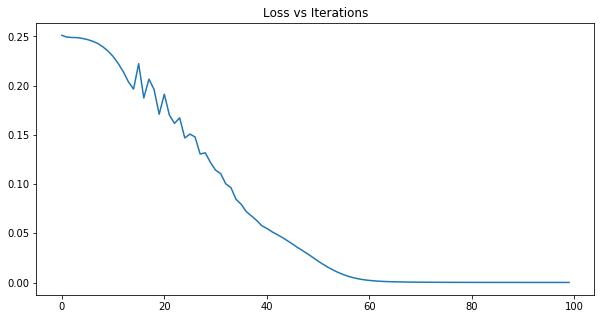

In [ ]:
# Make sure we're starting from untrained every time
tutorial_model = torch.load("/home/tutorial_model_default_state")

# Define a learning function, needs to be reinitialized every load
optimizer = torch.optim.Adam(tutorial_model.parameters(), lr = learning_rate)

# Train the network using our training procedure with the sample data
print("Below is the loss graph for our training session")
train_network(samples[0], samples[1], iterations = 100)

Okay, so we've trained our network on the sample data and now what's next? Let's classify the remaining sample test data to see if it the training actually worked.

Below we classify data that the network did not train on to see if it can extrapolate from the training set it **did** learn from.

Positive Test 1 Value scored: 98.68%
Positive Test 2 Value scored: 99.10%
Positive Test 3 Value scored: 99.01%
Positive Test 4 Value scored: 99.25%
Positive Test 5 Value scored: 98.91%
Positive Test 6 Value scored: 99.08%
Positive Test 7 Value scored: 98.82%
Positive Test 8 Value scored: 99.01%
Positive Test 9 Value scored: 98.30%
Positive Test 10 Value scored: 99.24%

Negative Test 1 Value scored: 1.38%
Negative Test 2 Value scored: 1.15%
Negative Test 3 Value scored: 1.68%
Negative Test 4 Value scored: 1.11%
Negative Test 5 Value scored: 0.97%
Negative Test 6 Value scored: 0.81%
Negative Test 7 Value scored: 0.79%
Negative Test 8 Value scored: 0.88%
Negative Test 9 Value scored: 0.66%
Negative Test 10 Value scored: 1.06%

Below is a scatter plot of some of the samples
Notice the distinct areas of red and green dots. If the input of this 
network was a simple x and y coordinate, the square band in the center would 
represent the "solution space" of our network. However, an actual EEG 

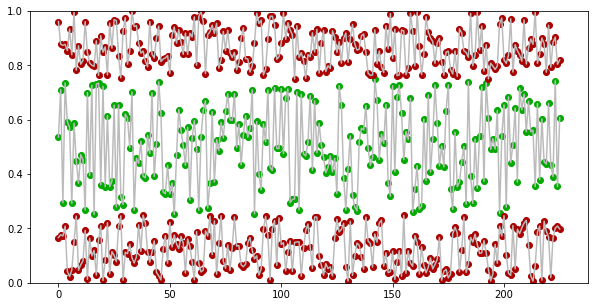

In [ ]:
# Classify our positive test dataset
predicted_positives = tutorial_model(test_positives).data.tolist()

# Print the results
for index, value in enumerate(predicted_positives):
  print("Positive Test {1} Value scored: {0:.2f}%".format(value[0] * 100, index + 1))

print()

#Classify the negative test dataset
predicted_negatives = tutorial_model(test_negatives).data.tolist()

# Print the results
for index, value in enumerate(predicted_negatives):
  print("Negative Test {1} Value scored: {0:.2f}%".format(value[0] * 100, index + 1))

print()


print("Below is a scatter plot of some of the samples")
print("Notice the distinct areas of red and green dots. If the input of this \n" +
"network was a simple x and y coordinate, the square band in the center would \n" +
"represent the \"solution space\" of our network. However, an actual EEG signal \n" +
"sample is an array of several points and can cross the boundry at any time.")
print("Plotted is one positive sample in green and two negative samples in red")

rcParams['figure.figsize'] = 10, 5
plt.scatter(list(range(0, eeg_sample_length)), test_positives[3], color = "#00aa00")
plt.plot(list(range(0, eeg_sample_length)), test_positives[3], color = "#bbbbbb")
plt.scatter(list(range(0, eeg_sample_length)), test_negatives[0], color = "#aa0000")
plt.plot(list(range(0, eeg_sample_length)), test_negatives[0], color = "#bbbbbb")
plt.scatter(list(range(0, eeg_sample_length)), test_negatives[9], color = "#aa0000")
plt.plot(list(range(0, eeg_sample_length)), test_negatives[9], color = "#bbbbbb")
plt.ylim([0 , 1])
plt.show()

It appears that our network is correctly classifying a simple set of fake EEG data is and ready to be tested out with actual samples. We're almost ready to solve our P300 problem. 

It is left to the reader to perform more experimentation with the sample data by adding overlap between good and bad datasets for example.

# (Step 7) Retrieve Data from the MNE EEG Dataset

The MNE library is a resource that specializes on brain signal processing, and provides access to sample databases. We will use one of these P300 databases to train our network.

In [ ]:
data_path = mne.datasets.sample.data_path()
data_path

Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|██████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 572GB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


MNEPosixPath('/root/mne_data/MNE-sample-data')

In order to obtain this database using `Python`, we need to set the path to the specific dataset we are going to use. In this case it is the sample audiovisual database, where the brainwaves have been filtered from 0 to 40 Hz. 

The data we obtain is **raw**. This means that it is simply a collection of streamed brain signal samples from many EEG channels, as opposed to signals sliced or focused to an event of interest. 

In [ ]:
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'

# Obtain a reference to the database and preload into RAM
raw_data = mne.io.read_raw_fif(raw_fname, preload=True) 

# EEGs work by detecting the voltage between two points. The second reference
# point is set to be the average of all voltages using the following function.
# It is also possible to set the reference voltage to a different number.
raw_data.set_eeg_reference()

Opening raw data file /root/mne_data/MNE-sample-data//MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


<ipython-input-13-1ea6c855818e>:1: DeprecationWarning: data_path functions now return pathlib.Path objects which do not natively support the plus (+) operator, switch to using forward slash (/) instead. Support for plus will be removed in 1.2.
  raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
<ipython-input-13-1ea6c855818e>:2: DeprecationWarning: data_path functions now return pathlib.Path objects which do not natively support the plus (+) operator, switch to using forward slash (/) instead. Support for plus will be removed in 1.2.
  event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'


Reading 0 ... 41699  =      0.000 ...   277.709 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Created an SSP operator (subspace dimension = 3)


<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~122.9 MB, data loaded>

Here we load the database and save it in a variable called `raw_data`. The `pick` function allows us to choose the sources of interest. For this tutorial we are picking the data from the `EEG` electrodes. `EOG` is also included as those are captured using the same electrodes. 

This dataset also includes the data from `MEG` (magnetoencephalography). However, `MEG` is still very far from being an accessible technology, due to the device being the size of a room. It also requires superconductors to function, similar to `fMRI`.

In [ ]:
# Define what data we want from the dataset
raw_data = raw_data.pick(picks=["eeg","eog"])
picks_eeg_only = mne.pick_types(raw_data.info, 
                                eeg=True, 
                                eog=True, 
                                meg=False, 
                                exclude='bads')

Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


The raw EEG file comes with events that allow us to know when something happened during the EEG recording. For example, events with id 5 correspond to when participants were presented with smiley faces, while events 1 through 4 corresponds to trials were participants were presented with a checkerboard either on the left side or the right side of the screen and with a tone presented to either the left ear or the right ear. 
We know that the trials were participants were presented with a smiley (events with id 5) will elicit a P300. So we will start by slicing (or epoching) the data 0.5 seconds before the image was presented (to have a baseline) and 1 second after the image was presented. We can change this to values closer to 0.3 seconds, which would crop exactly to where the P300 is. 


In [ ]:
events = mne.read_events(event_fname)
event_id = 5
tmin = -0.5 
tmax = 1
epochs = mne.Epochs(raw_data, events, event_id, tmin, tmax, proj=True,
                    picks=picks_eeg_only, baseline=(None, 0), preload=True,
                    reject=dict(eeg=100e-6, eog=150e-6), verbose = False)
print(epochs)

<Epochs |  12 events (all good), -0.499488 - 0.998976 sec, baseline -0.499488 – 0 sec, ~4.2 MB, data loaded,
 '5': 12>


Unfortunately, this dataset only has 12 P300 event examples. Normally, a practical application should have at least 100 examples, but we'll try anyway.

Specifically, we want a single `EEG` channel that has the highest indication of a P300 component to train our network with. It is possible to use more than one channel, but for simplicity we will use just one in this tutorial. The sensor plot below shows the name of the `EEG` channel we're using.

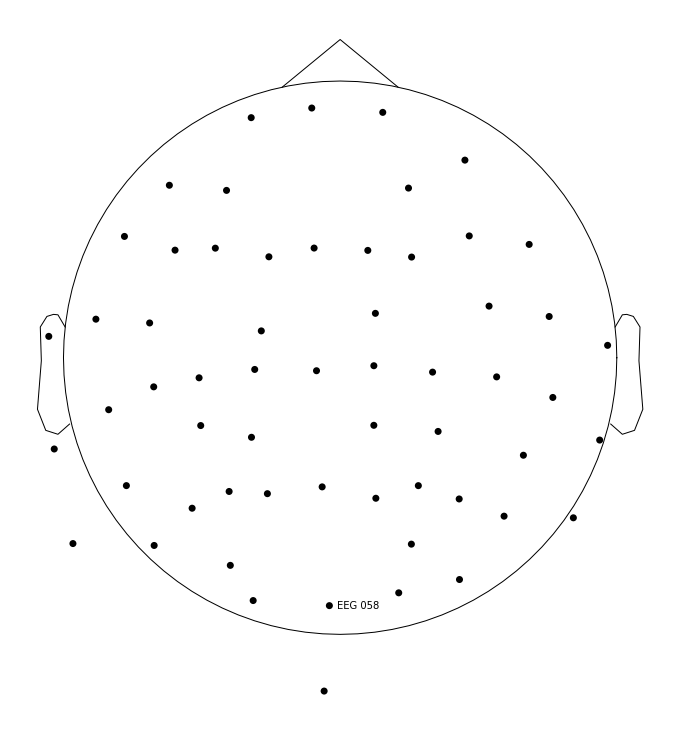

In [ ]:
# This is the channel used to monitor the P300 response
channel = "EEG 058"

# Display a graph of the sensor position we're using
sensor_position_figure = epochs.plot_sensors(show_names=[channel])

Below is a heat graph representing the 12 P300 events found within the dataset. If you look closely around the `0.3sec -> 0.4sec` mark, you can see there is a noticable deflection in the signal. **That is the P300 component**, and the difficulty of detecting it is immediately clear, even with the line graph below the heat graph being the average of the 12 samples.

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


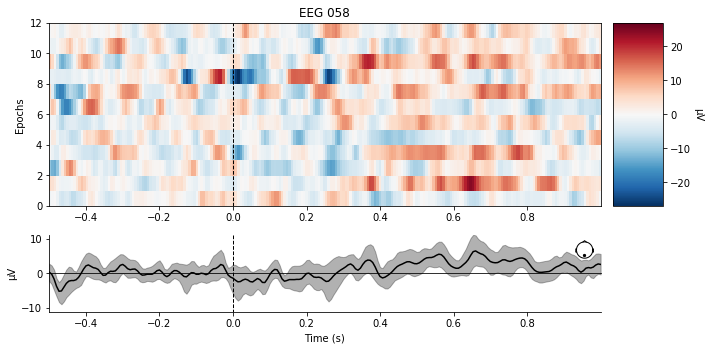

[<Figure size 720x360 with 4 Axes>]

In [ ]:
epochs.plot_image(picks=channel)

Now that we have our P300 component data, we need counter examples to contrast that data with. We'll gather all of the other miscellaneous events contained within that dataset as well.

In [ ]:
event_id=[1,2,3,4]
epochsNoP300 = mne.Epochs(raw_data, events, event_id, tmin, tmax, proj=True,
                    picks=picks_eeg_only, baseline=(None, 0), preload=True,
                    reject=dict(eeg=100e-6, eog=150e-6), verbose = False)
print(epochsNoP300)

<Epochs |  208 events (all good), -0.499488 - 0.998976 sec, baseline -0.499488 – 0 sec, ~24.5 MB, data loaded,
 '1': 47
 '2': 56
 '3': 57
 '4': 48>


There are significantly more Non-P300 events in this dataset, so we will only be using a subset to keep a needed balance between class data. The most important thing to notice about the plot below is that there is no significant deflection around the `0.3sec -> 0.4sec` time interval for the average of the data. 

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


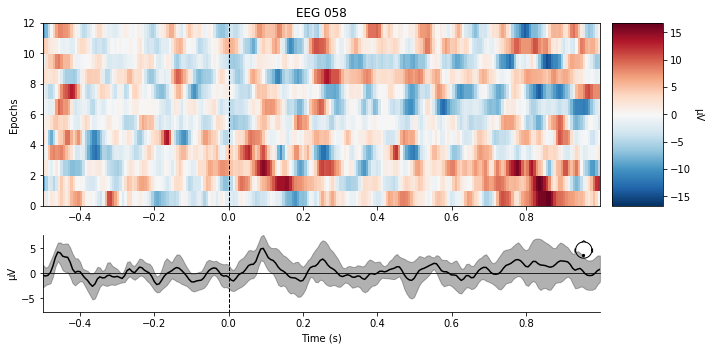

[<Figure size 720x360 with 4 Axes>]

In [ ]:
epochsNoP300[0:12].plot_image(picks=channel)

Here is one more useful all-in-one graph to visualize what these samples look like. Note that the image described in the sample problem earlier in the tutorial is shown at `time = 0sec`. The blue line corresponds to when the subject was shown a smiley face, and the orange line corresponds to when the subject was shown a checkerboard.

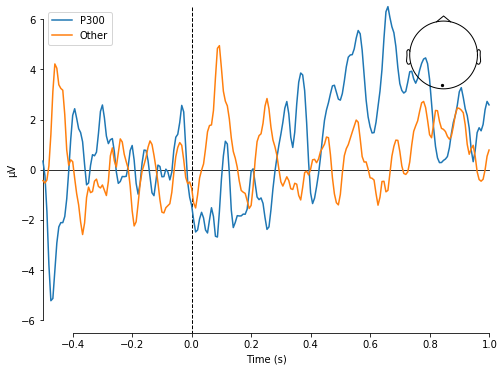

[<Figure size 576x432 with 2 Axes>]

In [ ]:
mne.viz.plot_compare_evokeds({'P300': epochs.average(picks=channel), 'Other': epochsNoP300[0:12].average(picks=channel)})

We've got a few more steps to take to fully transform our dataset data into something easily digestible by the neural network. We need to:


*   Scale the data while being mindful of possible outliers. If we just scale the data using the minimum and the maximum values of our dataset, we run the risk that our data gets defined by outliers and the regular values get squeezed in the center. To avoid this, we can use some statistical values (such as anything a few standard deviations from the  mean) to scale our data. 
*   Create a label variable, where the P300 samples are labeled as 1 and the Non-P300 samples are labeled as 0.
*   Combine the data into a single data structure.
*   Perform various data type conversions.

The code block below does all of this.

In [ ]:
eeg_data_scaler = RobustScaler()

# We have 12 p300 samples
p300s = np.squeeze(epochs.get_data(picks=channel))

# We have 208 non-p300 samples
others = np.squeeze(epochsNoP300.get_data(picks=channel))

# Scale the p300 data using the RobustScaler
p300s = p300s.transpose()
p300s = eeg_data_scaler.fit_transform(p300s)
p300s = p300s.transpose()

# Scale the non-p300 data using the RobustScaler
others = others.transpose()
others = eeg_data_scaler.fit_transform(others)
others = others.transpose()

## Prepare the train and test tensors
# Specify Positive P300 train and test samples
p300s_train = p300s[0:9]
p300s_test = p300s[9:12]
p300s_test = torch.tensor(p300s_test).float()

# Specify Negative P300 train and test samples
others_train = others[30:39]
others_test = others[39:42]
others_test = torch.tensor(others_test).float()

# Combine everything into their final structures
training_data = torch.tensor(np.concatenate((p300s_train, others_train), axis = 0)).float()
positive_testing_data = torch.tensor(p300s_test).float()
negative_testing_data = torch.tensor(others_test).float()

# Print the size of each of our data structures
print("training data count: " + str(training_data.shape[0]))
print("positive testing data count: " + str(positive_testing_data.shape[0]))
print("negative testing data count: " + str(negative_testing_data.shape[0]))

# Generate training labels
labels = torch.tensor(np.zeros((training_data.shape[0],1))).float()
labels[0:10] = 1.0
print("training labels count: " + str(labels.shape[0]))

training data count: 18
positive testing data count: 3
negative testing data count: 3
training labels count: 18


#(Step 8) Classify the Dataset with the Neural Network



Using the network definition created in `Step 5`, we'll train on our real `EEG` data this time, beginning from defaulted weights, prior to any training with the sample data we created.

Below is the loss graph for dataset training session


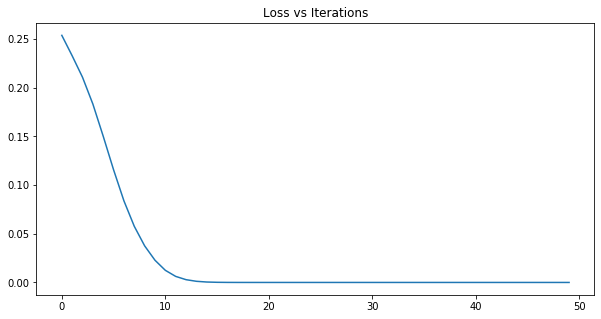

In [ ]:
# Make sure we're starting from untrained every time
tutorial_model = torch.load("/home/tutorial_model_default_state")

# Define a learning function, needs to be reinitialized every load
optimizer = torch.optim.Adam(tutorial_model.parameters(), lr = learning_rate)

# Use our training procedure with the sample data
print("Below is the loss graph for dataset training session")
train_network(training_data, labels, iterations = 50)

Alright, the moment of truth! Let's classify our test data sets.

In [ ]:
# Classify our positive test dataset and print the results
classification_1 = tutorial_model(positive_testing_data)
for index, value in enumerate(classification_1.data.tolist()):
  print("P300 Positive Classification {1}: {0:.2f}%".format(value[0] * 100, index + 1))

print()

# Classify our negative test dataset and print the results
classification_2 = tutorial_model(negative_testing_data)
for index, value in enumerate(classification_2.data.tolist()):
  print("P300 Negative Classification {1}: {0:.2f}%".format(value[0] * 100, index + 1))


P300 Positive Classification 1: 100.00%
P300 Positive Classification 2: 99.94%
P300 Positive Classification 3: 100.00%

P300 Negative Classification 1: 99.92%
P300 Negative Classification 2: 0.04%
P300 Negative Classification 3: 0.00%


Oh no, while the P300 Positive test samples did very well, one of the P300 Negative samples was misclassified! This is in part a consequence of not having enough data to train on. The network was unable to discern the difference between one of the Negative samples and the rest of the Positive samples. Let's take a look at what these samples look like next to each other.

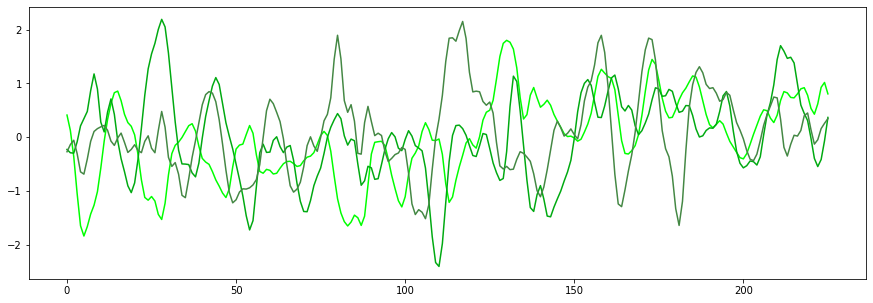

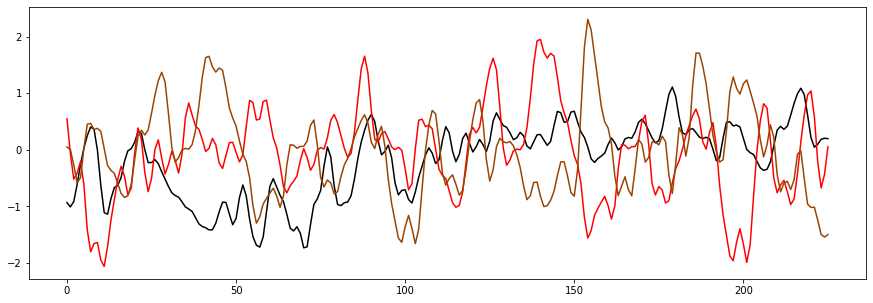

In [ ]:
rcParams['figure.figsize'] = 15, 5

plt.plot(list(range(0, eeg_sample_length)), positive_testing_data[0], color = "#00ff00")
plt.plot(list(range(0, eeg_sample_length)), positive_testing_data[1], color = "#00aa11")
plt.plot(list(range(0, eeg_sample_length)), positive_testing_data[2], color = "#448844")
plt.show()
plt.plot(list(range(0, eeg_sample_length)), negative_testing_data[0], color = "black")
plt.plot(list(range(0, eeg_sample_length)), negative_testing_data[1], color = "r")
plt.plot(list(range(0, eeg_sample_length)), negative_testing_data[2], color = "#994400")
plt.show()

So what happened here? The black line on the second graph is our offender. Visually, it looks similar enough to the Positive samples that it could easily be mistaken for one. Our network would require siginificantly more examples before it could distinguish samples like this.

Generally, it's recommended to have at least 100 samples to train on for each class. In this case we only had 9! Not enough for a true application, but enough for a proof of concept. With more samples, the network can develop a more complex and robust solution to classification.

# (Extra) Visualize the Network

Sometimes it can be difficult to understand what's happening with neural networks without a good visualization. Let's employ torchviz to help us make some sense of what's going on in this tutorial.

In [ ]:
pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=8f7560a634013d07035742a27669c6143b155f661c336f222bf91231934cb155
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


First, let's visualize the neural network itself. Using pytorchviz, it's possible to visually map the path data takes though our neural network. The code used to create this image is commented out since it generates a PDF instead of a collab-friendly image. [Pytorchviz is available on Github.](https://github.com/szagoruyko/pytorchviz)

![Network Graph](https://github.com/SiebertBrandon/Miscellaneous/blob/master/BCINNGraphResized.png?raw=true)

Finally, we can take a visual inspection of the network's final weights after training. The layers are shown in order and each dot represents a single neuron in the network! Rememeber our network has layers with 226, 500, 1000, 100, 10 and 1 neuron(s). The input values also get a `bias` value added to them each layer represented by the .bias objects

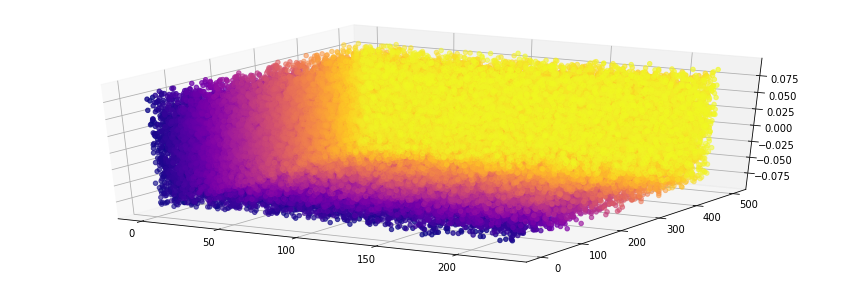

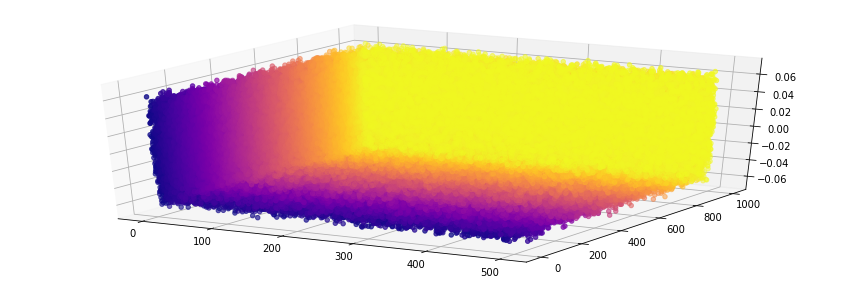

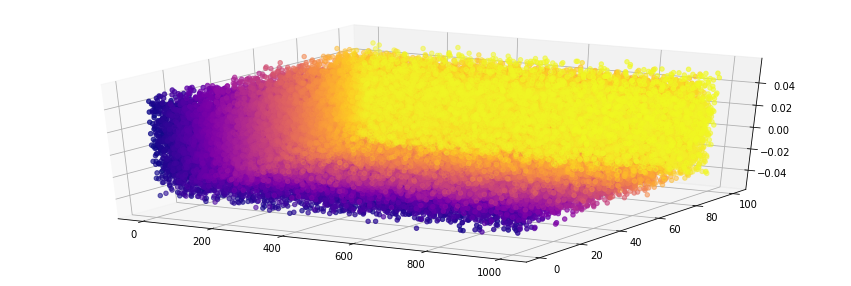

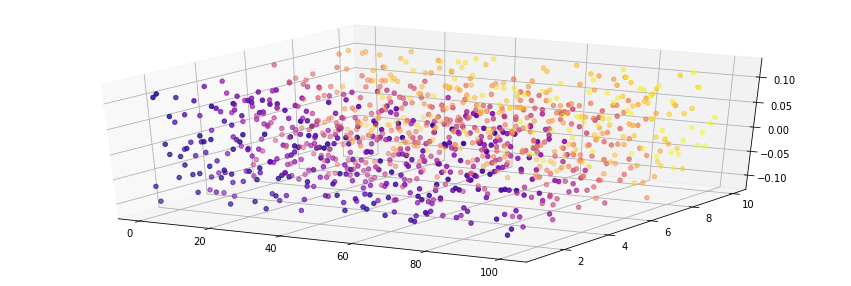

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig1 = plt.figure()
fig2 = plt.figure()
fig3 = plt.figure()
fig4 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax2 = fig2.add_subplot(111, projection='3d')
ax3 = fig3.add_subplot(111, projection='3d')
ax4 = fig4.add_subplot(111, projection='3d')

meta_parameters = dict(tutorial_model.named_parameters())
weight_data_input = meta_parameters['Input Linear.weight'].data.detach().numpy()
weight_data_hidden1 = meta_parameters['Hidden Linear.weight'].data.detach().numpy()
weight_data_hidden2 = meta_parameters['Hidden Linear2.weight'].data.detach().numpy()
weight_data_hidden3 = meta_parameters['Hidden Linear3.weight'].data.detach().numpy()
weight_data_output = meta_parameters['Output Linear.weight'].data.detach().numpy()

rcParams['figure.figsize'] = 10, 5

# Grab some test data.
X_1, Y_1 = np.meshgrid(range(1, 227), range(1, 501))
X_2, Y_2 = np.meshgrid(range(1, 501), range(1, 1001))
X_3, Y_3 = np.meshgrid(range(1, 1001), range(1, 101))
X_4, Y_4 = np.meshgrid(range(1, 101), range(1, 11))
X_5, Y_5 = np.meshgrid(range(1, 11), range(1, 1))

ax1.scatter(X_1, Y_1, weight_data_input, c = range(1, 113001), cmap = cm.plasma)
ax2.scatter(X_2, Y_2, weight_data_hidden1, c = range(1, 500001), cmap = cm.plasma)
ax3.scatter(X_3, Y_3, weight_data_hidden2, c = range(1, 100001), cmap = cm.plasma)
ax4.scatter(X_4, Y_4, weight_data_hidden3, c = range(1, 1001), cmap = cm.plasma)
plt.show()

In [ ]:
# Let's take a look at the rest of the negative samples
others_train = others[30:39]
others_test = others[39:42]
rest_of_the_negative_samples = np.concatenate((others[0:30], others[42:208]), axis = 0)
rest_test = torch.tensor(rest_of_the_negative_samples)

# Combine to a torch tensor
rest_testing_data = torch.tensor(rest_test).float()

# Print the size Try
print("rest of the testing data count: " + str(rest_testing_data.shape[0]))

# Classify the rest of our data
classification = tutorial_model(rest_testing_data)
total_value = 0
number_correct = 0
for index, value in enumerate(classification.data.tolist()):
  print("P300 Negative Classification {1}: {0:.2f}%".format(value[0] * 100, index + 1))
  total_value += value[0] * 100
  if (value[0] < 0.5):
    number_correct += 1

print()
print("Average Negative Score: {0:.2f}%".format(total_value / 196))
print("Proportion of Non-P300s Classified Correctly: {0:.2f}%".format(float(number_correct) / 196.0 * 100.0))

rest of the testing data count: 196
P300 Negative Classification 1: 5.34%
P300 Negative Classification 2: 25.55%
P300 Negative Classification 3: 100.00%
P300 Negative Classification 4: 69.90%
P300 Negative Classification 5: 27.42%
P300 Negative Classification 6: 0.02%
P300 Negative Classification 7: 0.00%
P300 Negative Classification 8: 0.02%
P300 Negative Classification 9: 0.07%
P300 Negative Classification 10: 0.00%
P300 Negative Classification 11: 62.20%
P300 Negative Classification 12: 0.02%
P300 Negative Classification 13: 0.13%
P300 Negative Classification 14: 99.96%
P300 Negative Classification 15: 0.00%
P300 Negative Classification 16: 0.00%
P300 Negative Classification 17: 0.45%
P300 Negative Classification 18: 0.00%
P300 Negative Classification 19: 0.00%
P300 Negative Classification 20: 1.58%
P300 Negative Classification 21: 88.51%
P300 Negative Classification 22: 10.35%
P300 Negative Classification 23: 92.66%
P300 Negative Classification 24: 0.18%
P300 Negative Classificatio

Not perfect, but better than random chance. Try modifying this tutorial by adding a dataset with more datapoints!